In [2]:
import glob
import os
import time
import random
import numpy as np
import pandas as pd
import hashlib
import multiprocessing
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F
import torchmetrics.classification.accuracy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image, ImageDraw

%matplotlib inline

# Задача: научиться классифицировать симпсонов, то есть мы должны решить задачу мультиклассовой классификации

## определим некоторые "константы", которые мы будем использовать в дальнейшем

In [3]:
data_path = "data\simpsons_dataset"
test_path = "data\kaggle_simpson_testset\kaggle_simpson_testset"
batch_size = 64
random_seed = 42

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

#

In [4]:
image_data = {}

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            class_name = os.path.basename(root)
            if class_name not in image_data:
                image_data[class_name] = []
            image_data[class_name].append(os.path.join(root, file))

df_images = pd.DataFrame(image_data.items(), columns=['Class', 'Images'])
df_images

,Class,Images
0,abraham_grampa_simpson,[data\simpsons_dataset\abraham_grampa_simpson\...
1,agnes_skinner,[data\simpsons_dataset\agnes_skinner\pic_0000....
2,apu_nahasapeemapetilon,[data\simpsons_dataset\apu_nahasapeemapetilon\...
3,barney_gumble,[data\simpsons_dataset\barney_gumble\pic_0000....
4,bart_simpson,[data\simpsons_dataset\bart_simpson\pic_0000.j...
5,carl_carlson,[data\simpsons_dataset\carl_carlson\pic_0000.j...
6,charles_montgomery_burns,[data\simpsons_dataset\charles_montgomery_burn...
7,chief_wiggum,[data\simpsons_dataset\chief_wiggum\pic_0000.j...
8,cletus_spuckler,[data\simpsons_dataset\cletus_spuckler\pic_000...
9,comic_book_guy,[data\simpsons_dataset\comic_book_guy\pic_0000...


In [5]:
image_hashes = {}
duplicates = []

for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            with open(os.path.join(root, file), 'rb') as f:
                image_data = f.read()
            image_hash = hashlib.md5(image_data).hexdigest()
            
            if image_hash in image_hashes:
                duplicates.append({"Original": image_hashes[image_hash], "Duplicate": os.path.join(root, file)})
                print(f"Duplicate image found: {file}")
                print(f"Original image: {image_hashes[image_hash]}")
                print(f"Duplicate image: {os.path.join(root, file)}")
                print("----------------------------------------")
            else:
                image_hashes[image_hash] = os.path.join(root, file)

df_duplicates = pd.DataFrame(duplicates)

Duplicate image found: pic_0012.jpg
Original image: data\simpsons_dataset\cletus_spuckler\pic_0010.jpg
Duplicate image: data\simpsons_dataset\cletus_spuckler\pic_0012.jpg
----------------------------------------
Duplicate image found: pic_0262.jpg
Original image: data\simpsons_dataset\lenny_leonard\pic_0257.jpg
Duplicate image: data\simpsons_dataset\lenny_leonard\pic_0262.jpg
----------------------------------------
Duplicate image found: pic_0176.jpg
Original image: data\simpsons_dataset\mayor_quimby\pic_0054.jpg
Duplicate image: data\simpsons_dataset\mayor_quimby\pic_0176.jpg
----------------------------------------
Duplicate image found: pic_0014.jpg
Original image: data\simpsons_dataset\professor_john_frink\pic_0012.jpg
Duplicate image: data\simpsons_dataset\professor_john_frink\pic_0014.jpg
----------------------------------------
Duplicate image found: pic_0016.jpg
Original image: data\simpsons_dataset\rainier_wolfcastle\pic_0011.jpg
Duplicate image: data\simpsons_dataset\rainier

In [6]:
df_duplicates

,Original,Duplicate
0,data\simpsons_dataset\cletus_spuckler\pic_0010...,data\simpsons_dataset\cletus_spuckler\pic_0012...
1,data\simpsons_dataset\lenny_leonard\pic_0257.jpg,data\simpsons_dataset\lenny_leonard\pic_0262.jpg
2,data\simpsons_dataset\mayor_quimby\pic_0054.jpg,data\simpsons_dataset\mayor_quimby\pic_0176.jpg
3,data\simpsons_dataset\professor_john_frink\pic...,data\simpsons_dataset\professor_john_frink\pic...
4,data\simpsons_dataset\rainier_wolfcastle\pic_0...,data\simpsons_dataset\rainier_wolfcastle\pic_0...
5,data\simpsons_dataset\waylon_smithers\pic_0038...,data\simpsons_dataset\waylon_smithers\pic_0051...


In [7]:
size_with_dub = df_images.size
for index, row in df_duplicates.iterrows():
        df_images = df_images[~df_images['Images'].apply(lambda x: set(x) == set(row['Duplicate']))]

In [8]:
class_count = df_images.explode('Images').groupby('Class').size().reset_index(name='Image Count')
df_image_count = pd.DataFrame(class_count)
df_image_count

,Class,Image Count
0,abraham_grampa_simpson,913
1,agnes_skinner,42
2,apu_nahasapeemapetilon,623
3,barney_gumble,106
4,bart_simpson,1342
5,carl_carlson,98
6,charles_montgomery_burns,1193
7,chief_wiggum,986
8,cletus_spuckler,47
9,comic_book_guy,469


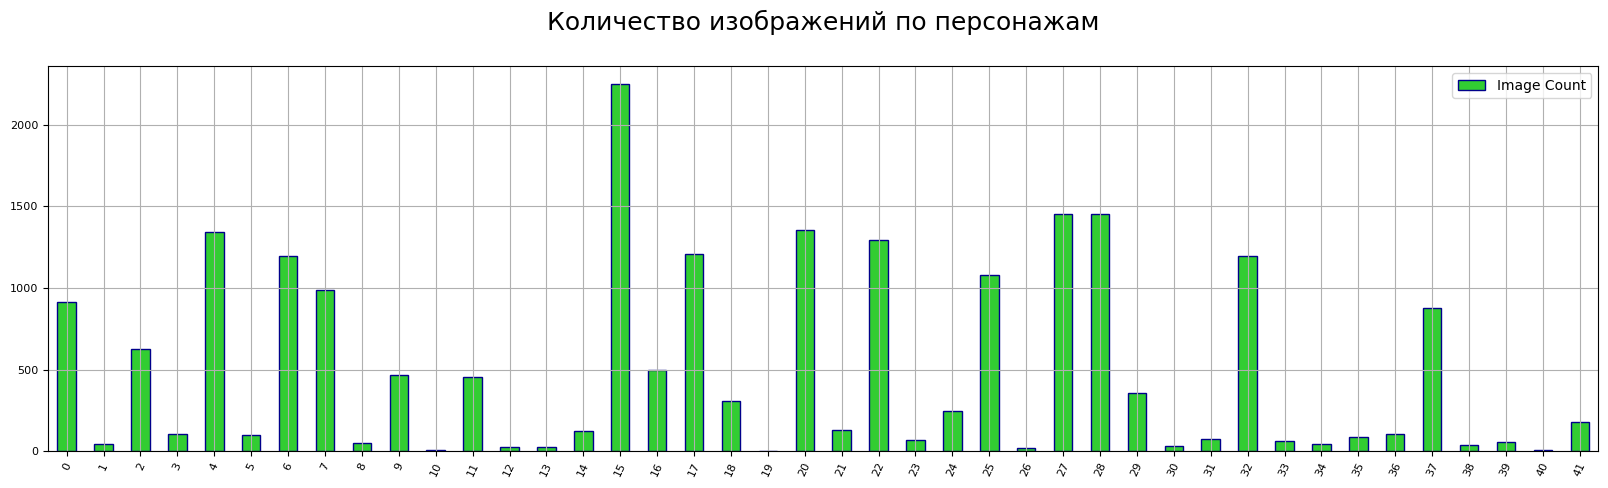

In [9]:
plot = df_image_count.plot.bar(
    figsize=(20, 5), fontsize=8, color='limegreen', 
    edgecolor='darkblue', linewidth=1, title='Количество изображений по персонажам\n')
plot.title.set_size(18)
plot.legend(loc=1, fontsize=10)
plot.set(ylabel=None, xlabel=None)
plot.grid()
plt.xticks(rotation=65)
plt.show()

### Видим, что у нас сильный дизбаланс классов: где-то изображений 2000, а где-то и 10 нет => придется исправить это

In [10]:
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'edge')

In [11]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, files,  mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.l_e = LabelEncoder()
        self.rescale_size = 244
        self.labels=[]
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.l_e.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.l_e, le_dump_file)
        else:
            self.filenames = [path.name for path in test_files]
            for file in self.filenames:
                self.class_name=""
                self.parts = str(file).split('_')
                for part in self.parts:
                    if '.' in part:
                        break
                    self.class_name += part + '_'
                self.labels.append(self.class_name.rstrip('_'))
            
            with open('label_encoder.pkl', 'rb') as file:
                self.l_e = pickle.load(file)
            
            
            
    def __len__(self):
        return len(self.files)
    
    def create_transformer(self):
        if self.mode == "train":
            transformer = transforms.Compose([
                SquarePad(),
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.RandomRotation(2.8),
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(contrast=0.9)], p=0.5),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(brightness=0.1)], p=0.5),
                ]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
        else:
            transformer = transforms.Compose([
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
        return transformer
    
    def load_sample(self, im_file):
        image = Image.open(im_file)
        image.load()
        return image
    
    def __getitem__(self, idx):
        transform = self.create_transformer()    
        x = self.load_sample(self.files[idx])
        x = transform(x)
        label = self.labels[idx]
        label_id = self.l_e.transform([label])
        y = label_id.item()
        return x, y

In [ ]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, files,  mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.l_e = LabelEncoder()
        self.rescale_size = 244
        self.labels=[]
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
        if self.mode == "train":
            for 
        
            self.l_e.fit(self.labels)
        
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.l_e, le_dump_file)
        else:
            self.filenames = [path.name for path in test_files]
            for file in self.filenames:
                self.class_name=""
                self.parts = str(file).split('_')
                for part in self.parts:
                    if '.' in part:
                        break
                    self.class_name += part + '_'
                self.labels.append(self.class_name.rstrip('_'))
            
            with open('label_encoder.pkl', 'rb') as file:
                self.l_e = pickle.load(file)
            
            
            
    def __len__(self):
        return len(self.files)
    
    def create_transformer(self):
        if self.mode == "train":
            transformer = transforms.Compose([
                SquarePad(),
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.RandomRotation(2.8),
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(contrast=0.9)], p=0.5),
                    transforms.RandomApply([transforms.RandomHorizontalFlip(
                        p=1), transforms.ColorJitter(brightness=0.1)], p=0.5),
                ]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
        else:
            transformer = transforms.Compose([
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
        return transformer
    
    def load_sample(self, im_file):
        image = Image.open(im_file)
        image.load()
        return image
    
    def __getitem__(self, idx):
        transform = self.create_transformer()    
        x = self.load_sample(self.files[idx])
        x = transform(x)
        label = self.labels[idx]
        label_id = self.l_e.transform([label])
        y = label_id.item()
        return x, y

In [12]:
from pathlib import Path

train_val_files_lst = []
images_lst = sorted(df_images['Images'].tolist())
train_val_files_lst = [Path(item) for sublist in images_lst for item in sublist]

In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files_lst]
train_files, val_files = train_test_split(train_val_files_lst, test_size=0.2, random_state=random_seed, stratify=train_val_labels)

In [14]:
train_dataset = SimpsonsDataset(train_files, mode="train")
val_dataset = SimpsonsDataset(val_files, mode="val")

In [15]:
def get_class_counts(dataset):
    class_counts = torch.zeros(42, 1)
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

In [14]:
def set_parameter_requires_grad(model, feature_extracting = False):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [20]:
def initialize_model(use_pretrained=False):
    model_ft = None
    num_classes = len(pd.unique(train_val_labels))
    model_ft = models.resnet152(pretrained=use_pretrained)
    #set_parameter_requires_grad(model_ft)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

In [21]:
def calculate_validation_loss(model, validation_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    return loss

In [52]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
                   'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False )}

In [ ]:
model_ft = initialize_model().to(device)
base_lr = 0.001
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_ft.parameters(), lr=0.001, weight_decay=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

accuracy = {"train": [], "val": []}
val_loss = []

for epoch in range(num_epochs):
    for k, dataloader in dataloaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model_ft.train()
                optimizer.zero_grad()
                outp = model_ft(x_batch)
            else:
                model_ft.eval()
                with torch.no_grad():
                    outp = model_ft(x_batch)
            preds = outp.argmax(-1)
            correct = (preds.detach() == y_batch).sum(dim=0)
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    if k == 'val' in dataloaders:
        val_loss.append(calculate_validation_loss(model_ft, dataloaders[k], criterion))
        print(f"Val_loss: {val_loss[-1]}")
    scheduler.step(val_loss[-1])


#del model_ft
del x_batch
del y_batch
torch.cuda.empty_cache()

In [40]:
test_files = sorted(Path(test_path).rglob('*.jpg'))
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [42]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [44]:
from sklearn.metrics import f1_score, precision_score, roc_curve, auc

def make_f1_score(model,dataset):

    n=len(dataset)
    idxs = list(map(int, np.random.uniform(0, n, n)))
    imgs = [dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims, -1)

    actual_labels = [dataset[id][1] for id in idxs]
    preds_class = list(y_pred)
    
    actual_labels = [dataset[id][1] for id in idxs]
    preds_class = list(y_pred)

    f1_micro = round(f1_score(actual_labels, preds_class, average='micro'), 3)
    precision_per_class = precision_score(actual_labels, preds_class, average=None)

    num_classes = len(list(set(actual_labels)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):  # Assuming num_classes is defined
        fpr[i], tpr[i], _ = roc_curve(actual_labels, probs_ims[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return f1_micro, precision_per_class

In [45]:
f1_val_micro, f1_val_per_class = make_f1_score(model_ft, val_dataset)

NameError: name 'model_ft' is not defined

In [46]:
f1_val_per_class

F1 score по каждому из классов в val датасете [0.04251254 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
F1 score на val датасете(микро) 0.043


In [ ]:
f1_val_micro

In [48]:
f1_test_micro,f1_test_per_class  = make_f1_score(model_ft, test_dataset)

NameError: name 'model_ft' is not defined

In [49]:
f1_test_micro  

0.052

In [50]:
f1_test_per_class

array([0.05151515, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])